# News articles Classification Unising CNN

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Using TensorFlow backend.


## Removing punctiuations & tabulations

In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    string = re.sub(r"/", " ", string)
    string = re.sub(r"-", " ", string)
    string = re.sub(r"\n", " ", string)
    string = re.sub(r"\r", " ", string)
    string = re.sub(r"\t", " ", string)
    return string.strip().lower()

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

## Importing Dataset

In [4]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='all',remove= ('headers', 'footers', 'quotes'))

In [0]:
targets = dataset.target_names
X = dataset.data
Y = dataset.target

In [0]:
texts = []
labels = Y

for x in X:
    texts.append(clean_str(x))

## Applying text preprocessing: tokenization

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 134998


## We need the text to be fixed length , Therefore we are uning padding

In [8]:

data  =  pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (18846, 1000)
Shape of Label Tensor: (18846, 20)


## Uploading Word embedding: Glove pretrained model

In [9]:
!wget -r http://nlp.stanford.edu/data/glove.6B.zip
!unzip nlp.stanford.edu/data/glove.6B.zip -d glove
!rm -r nlp.stanford.edu/

--2018-08-29 10:42:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-08-29 10:42:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘nlp.stanford.edu/data/glove.6B.zip’

nlp.stanford.edu/da 100%[===================>] 822.24M  7.96MB/s    in 81s     

2018-08-29 10:44:06 (10.1 MB/s) - ‘nlp.stanford.edu/data/glove.6B.zip’ saved [862182613/862182613]

FINISHED --2018-08-29 10:44:06--
Total wall clock time: 1m 22s
Downloaded: 1 files, 822M in 1m 21s (10.1 MB/s)
Archive:  nlp.stanford.edu/data/glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflat

## Set to every word its vector , if it exists.

In [10]:
embeddings_index = {}
f = open('glove/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:

embedding_matrix  = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

# Building the CNN

In [12]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(targets), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         13499900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 

## Training the model

In [13]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 15077 samples, validate on 3769 samples
Epoch 1/15
15077/15077 [==============================] - 159s 11ms/step - loss: 1.9909 - acc: 0.3653 - val_loss: 1.7411 - val_acc: 0.5023

Epoch 00001: val_acc improved from -inf to 0.50226, saving model to model_cnn.hdf5
Epoch 2/15
15077/15077 [==============================] - 158s 10ms/step - loss: 1.7702 - acc: 0.5178 - val_loss: 2.0288 - val_acc: 0.5627

Epoch 00002: val_acc improved from 0.50226 to 0.56275, saving model to model_cnn.hdf5
Epoch 3/15
15077/15077 [==============================] - 157s 10ms/step - loss: 1.8688 - acc: 0.5437 - val_loss: 2.9349 - val_acc: 0.4757

Epoch 00003: val_acc did not improve from 0.56275
Epoch 4/15
15077/15077 [==============================] - 158s 10ms/step - loss: 1.9497 - acc: 0.5567 - val_loss: 2.4861 - val_acc: 0.5054

Epoch 00004: val_acc did not improve from 0.56275
Epoch 5/15
15077/15077 [==============================] - 158s 10ms/step - loss: 2.1103 - acc: 0.5467 - val_loss: 2.4331 -

## Graph comparison: Train vs Validation
## loss & accuracy

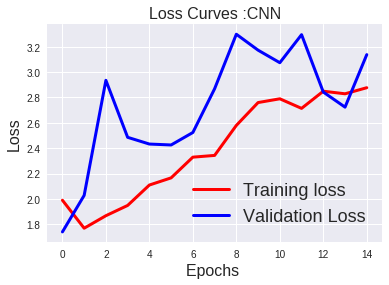

In [14]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

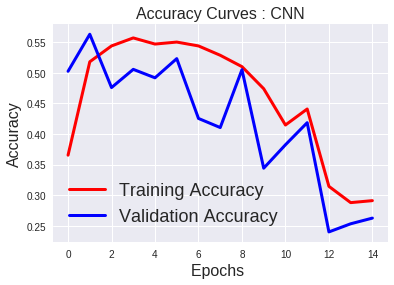

In [15]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

# Interpretation

### The best results is obtaining after 2 epochs: 

Train: - loss: 1.7702 - acc: 0.5178 
val_loss: 2.0288 - val_acc: 0.5627

### After that it went down:
20news dataset is a small, therefore the model learnt the best result possible after 2 epochs only. Hence we are  using batch=2   that  means the model iterates nearly throw all observations .

Using bigger dataset will improve the results. The last model we built was for text summarization we used 4M observation to get good results. 